# Get average number of patches per slide

In [15]:
!pip3 install --upgrade -qqq seaborn

In [1]:
import os
import h5py
import tqdm
import numpy as np
import pandas as pd

from pathlib import Path
from collections import defaultdict

In [2]:
os.chdir('/data/pathology/projects/ais-cap/code/git/clemsgrs/hipt')

In [3]:
root_dir = Path('/data/pathology/projects/ais-cap/code/git/clemsgrs/hs2p')

In [4]:
dataset_name = 'tcga_brca'
experiment_name = 'otsu'
patch_dir = Path(root_dir, 'output', dataset_name, experiment_name, 'patches')

In [5]:
patch_size = 4096

In [6]:
slide_patches = [s for s in patch_dir.iterdir()]
len(slide_patches)

875

In [7]:
data = defaultdict(list)
for d in slide_patches:
    slide_dir = Path(d, str(patch_size))
    slide_id = d.name
    h5py_fp = Path(slide_dir, f'{slide_id}.h5')
    p = h5py.File(h5py_fp, 'r')['coords']
    m = len(p)
    data['slide_id'].append(slide_id)
    data['M'].append(m)

In [8]:
M_df = pd.DataFrame.from_dict(data)
M_df.head()

,slide_id,M
0,TCGA-A2-A0CP-01Z-00-DX1.ECFD263C-BB17-4ADA-8F2...,29
1,TCGA-D8-A143-01Z-00-DX1.4697FB2F-91D5-4506-AF2...,60
2,TCGA-A2-A0CM-01Z-00-DX1.AC4901DE-4B6D-4185-BB9...,42
3,TCGA-AC-A8OS-01Z-00-DX1.3FD44846-8BD2-4A7A-9A8...,18
4,TCGA-PL-A8LX-01A-01-DX1.9646D69F-A764-4246-924...,9


In [9]:
M_df.M.mean()

52.093714285714285

In [10]:
M_df.M.min(), M_df.M.max()

(4, 177)

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
nslide = defaultdict(list)
dfs = []
nfold = 10
for i in range(nfold):
    fold_dir = Path(f'data/{dataset_name}/splits/fold_{i}')
    for partition in ['train', 'tune', 'test']:
        df = pd.read_csv(Path(fold_dir, f'{partition}.csv'))
        nslide[partition].append(len(df))
        df = M_df.merge(df, how='inner', on='slide_id')
        M = df.M.mean()
        tmp = pd.DataFrame.from_dict({'avg_M': [M], 'partition': [partition]})
        dfs.append(tmp)
        
df = pd.concat(dfs)
df.head()

,avg_M,partition
0,51.381818,train
0,54.126582,tune
0,56.395062,test
0,51.278481,train
0,58.321429,tune


In [13]:
avg_nslide = [np.mean(nslide[p]) for p in ['train', 'tune', 'test']]
avg_nslide

[712.9, 79.9, 82.2]

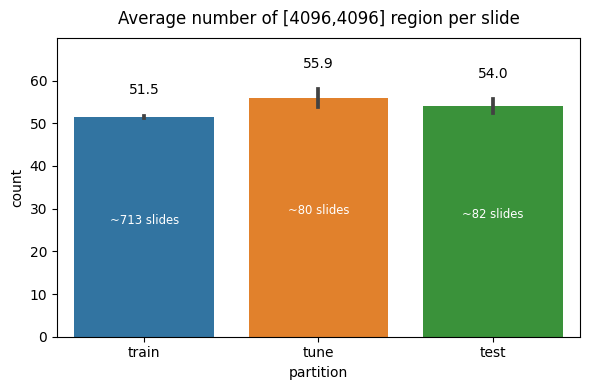

In [15]:
pad = 5
save = False

plt.figure(dpi=100)
ax = sns.barplot(data=df, y='avg_M', x='partition', errorbar='sd')
for i, p in enumerate(ax.patches):
    errbar = ax.lines[i].get_data()[1]
    std = errbar[1] - errbar[0]
    
    x, y = p.get_x(), p.get_y()
    w, h = p.get_width(), p.get_height()
    txt_x, txt_y = x+w/2, h+std/2+pad
    
    plt.text(txt_x, txt_y, f'{h:.1f}', horizontalalignment='center')
    
    n = avg_nslide[i]
    plt.text(x+w/2, h/2, f'~{n:.0f} slides', horizontalalignment='center', verticalalignment='bottom', fontsize='small', color='white')

plt.xlabel('partition')
plt.ylabel('count')
plt.ylim(0,df.avg_M.max()*1.2)
plt.title(f'Average number of [4096,4096] region per slide', pad=10)
plt.tight_layout()
if save:
    plt.savefig('notebooks/avg_M_partion.png', dpi=300)
plt.show()

### Breakdown per subtype

In [ ]:
nslide = {'train': defaultdict(list), 'tune': defaultdict(list), 'test': defaultdict(list)}
dfs = []
nfold = 10
for i in range(nfold):
    fold_dir = Path(f'data/{dataset_name}/splits/fold_{i}')
    for partition in ['train', 'tune', 'test']:
        df = pd.read_csv(Path(fold_dir, f'{partition}.csv'))
        df['subtype'] = df['label'].apply(lambda x: 'IDC' if x == 0 else 'ILC')
        for subtype, gdf in df.groupby('subtype'):
            nslide[partition][subtype].append(len(gdf))
            gdf = M_df.merge(gdf, how='inner', on='slide_id')
            M = gdf.M.mean()
            tmp = pd.DataFrame.from_dict({'avg_M': [M], 'partition': [partition], 'subtype': [subtype]})
            dfs.append(tmp)
        
df = pd.concat(dfs)
df.head()

In [ ]:
nslide

In [ ]:
avg_nslide = [np.mean(nslide[p][s]) for s in df.subtype.unique() for p in ['train', 'tune', 'test']]
avg_nslide

In [ ]:
pad = 10
save = True

plt.figure(dpi=100)
ax = sns.barplot(data=df, y='avg_M', hue='subtype', x='partition', errorbar='sd')
for i, p in enumerate(ax.patches):
    errbar = ax.lines[i].get_data()[1]
    std = errbar[1] - errbar[0]
    
    x, y = p.get_x(), p.get_y()
    w, h = p.get_width(), p.get_height()
    txt_x, txt_y = x+w/2, h+std/2+pad
    
    plt.text(txt_x, txt_y, f'{h:.1f}', horizontalalignment='center')
    
    n = avg_nslide[i]
    plt.text(x+w/2, h/2, f'~{n:.0f} slides', horizontalalignment='center', verticalalignment='bottom', fontsize='x-small', color='white')

plt.xlabel('partition')
plt.ylabel('count')
plt.ylim(0,349)
plt.title(f'Average number of [4096,4096] region per slide', pad=10)
plt.tight_layout()
if save:
    plt.savefig('notebooks/avg_M_subtype.png', dpi=300)
plt.show()

#### Compute number of regions from HIPT pre-extracted features

In [ ]:
import tqdm
import torch
import numpy as np
import pandas as pd

from pathlib import Path
from collections import defaultdict

In [ ]:
hipt_dir = Path('/home/user/code/git/opensource/tmp/HIPT')
d = 'embeddings_slide_lib'
features_root_dir = Path(hipt_dir, f'3-Self-Supervised-Eval/{d}/{d}/vit256mean_tcga_slide_embeddings')

In [ ]:
features_fp = list(features_root_dir.glob('*.pt'))
len(features_fp)

In [ ]:
data = defaultdict(list)

with tqdm.tqdm(
    features_fp,
    desc='Loading features',
    unit=' slide',
    ncols=80,
    leave=True,
) as t:
    for fp in t:
        slide_id = fp.stem
        feat = torch.load(fp)
        m = feat.shape[0]
        data['slide_id'].append(slide_id)
        data['M'].append(m)

In [ ]:
M_df = pd.DataFrame.from_dict(data)
M_df.head()

In [ ]:
M_df.M.mean()

In [ ]:
M_df.M.min(), M_df.M.max()